## Momentum練習

- 每一次移動的方式不是只有考慮gradient，而是現在的gradient加上前一個時間點移動的方向

In [2]:
#http://openclassroom.stanford.edu/MainFolder/DocumentPage.php?course=MachineLearning&doc=exercises/ex2/ex2.html

%pylab inline
import theano
import theano.tensor as T
import itertools as it
import time
import pandas as pd

def floatX(X):
    return np.asarray(X, dtype=theano.config.floatX)

### make batches
def mk_batches(x_data, y_data, batch_size, shuffle=False):
    x_batch = list()
    y_batch = list()
    
    x_data_size = x_data.shape[0]
    y_data_size = y_data.shape[0]
    assert x_data_size == y_data_size , 'the x, y dimension is error'
    
    if shuffle:
        indices = np.arange(x_data_size)
        np.random.shuffle(indices)
    
    #range(start, stop, step)
    for start_idx in range(0, x_data_size, batch_size):
        if shuffle:
            idx = indices[start_idx : start_idx + batch_size]            
        else:
            idx = slice(start_idx, start_idx + batch_size)
            
        x_batch.append(x_data[idx])
        y_batch.append(y_data[idx])
    
    return x_batch, y_batch
    
### data
batch_size = 10
x_data = floatX(np.loadtxt('.\ex2x.dat'))
y_data = floatX(np.loadtxt('.\ex2y.dat'))


### params / init weights
w = theano.shared(floatX(-1.))
b = theano.shared(floatX(-1.))

### model
x = T.vector()
y = w*x + b

### cost/error/loss
y_hat = T.vector()
cost = T.mean((y-y_hat)**2)

###############################################################################
### gradients
his_grad_dw = []
his_grad_db = []
second_dw = theano.shared(floatX(0.))
second_db = theano.shared(floatX(0.))

def gd(params, grads, lr):
    updates = []
        
    for p, g in it.izip(params, grads):
        updates.append([p, p - lr*g])

    return updates

def Adagd(params, grads):
    updates = []
    lr = floatX(1.)
    
    updates.append([params[0], params[0] - (lr/second_dw)*grads[0]])
    
    updates.append([params[1], params[1] - (lr/second_db)*grads[1]])
    
    return updates
    
def Rmsprop(params, grads):
    updates = []
    
    lr = floatX(0.01)
    
    updates.append([params[0], params[0] - (lr/second_dw)*grads[0]])
    
    updates.append([params[1], params[1] - (lr/second_db)*grads[1]])
    
    return updates

Populating the interactive namespace from numpy and matplotlib


## 使用momentum來update參數

In [3]:
his_move_dw = []
his_move_db = []
movement_dw = theano.shared(floatX(0.))
movement_db = theano.shared(floatX(0.))

def Momentum(params, grads):
    updates = []    
    
    updates.append([params[0], params[0] + movement_dw])
    
    updates.append([params[1], params[1] + movement_db])
    
    return updates

In [4]:
dw, db = T.grad(cost, [w, b])

In [5]:
###############################################################################
### calculate every step gradient's root mean square
def calc_second_derivative(x, y):
    g_dw = f_grad_dw(x, y)          
    g_db = f_grad_db(x, y) 
     
    his_grad_dw.append(g_dw)
    his_grad_db.append(g_db)
    
    second_dw.set_value(floatX(np.sqrt(np.sum(np.square(his_grad_dw)))))
    second_db.set_value(floatX(np.sqrt(np.sum(np.square(his_grad_db)))))

def calc_rms_derivative(x, y, i):
    
    # Hinton suggests alpha to be set to 0.9, while a good default value for the learning rate is 0.001.
    # 看問題而定，就我這個問題，用0.001的learning rate學很慢    
    a = 0.9
    
    g_dw = f_grad_dw(x, y)          
    g_db = f_grad_db(x, y) 
    
    if i == 0:
        his_grad_dw.append(g_dw)
        curr_sigam_dw = g_dw
        
        his_grad_db.append(g_db)
        curr_sigam_db = g_db
    else:
        pre_sigma_dw = his_grad_dw[i-1]
        curr_sigam_dw = np.sqrt ( a * np.square(pre_sigma_dw) + (1 - a) * np.square(g_dw) )
        his_grad_dw.append(curr_sigam_dw)
        
        pre_sigma_db = his_grad_db[i-1]
        curr_sigam_db = np.sqrt ( a * np.square(pre_sigma_db) + (1 - a) * np.square(g_db) )
        his_grad_db.append(curr_sigam_db)
    
    second_dw.set_value(floatX(curr_sigam_dw))    
    second_db.set_value(floatX(curr_sigam_db))

- lamda的意思是說對於慣性的影響有多大，lamda大慣性就大，lamda小慣性就小
- vi其實就是過去所有算出來gradient的總和
- 可以試著調整看看lamda值，越小就越不參考之前所有gradient的總和
- 那lamda設成0，會發生什麼事? 其實就是原本gradient descent一樣

In [7]:
def calc_momentum(x, y, i):
    
    lamda = 0.9
    lr = 0.01
    v = 0
    
    g_dw = f_grad_dw(x, y)          
    g_db = f_grad_db(x, y) 
    
    if i == 0:        
        new_v = lamda * v - lr * g_dw
        his_move_dw.append(new_v)
        
        new_v = lamda * v - lr * g_db
        his_move_db.append(new_v)
    else:
        v = his_move_dw[i-1]
        new_v = lamda * v - lr * g_dw
        his_move_dw.append(new_v)
        
        v = his_move_db[i-1]
        new_v = lamda * v - lr * g_db
        his_move_db.append(new_v)
    
    movement_dw.set_value(floatX(his_move_dw[i]))    
    movement_db.set_value(floatX(his_move_db[i]))

(Sgd) minimum result 
 cost         0.00246202
w       0.0751429959527
b        0.682478768864
Name: 293, dtype: object
It costs 0.510000 sec 

(Adagrad) minimum result 
 cost         0.00187653
w       0.0662838883626
b        0.752613737381
Name: 192, dtype: object
It costs 0.800000 sec 

(Rmsprop) minimum result 
 cost         0.00188147
w       0.0622762603861
b        0.746160713387
Name: 218, dtype: object
It costs 0.660000 sec 

(Momentum) minimum result 
 cost         0.00190645
w       0.0610319143142
b         0.75064479578
Name: 138, dtype: object
It costs 0.639000 sec 

(closed-fom) w=0.0639, b= 0.7502


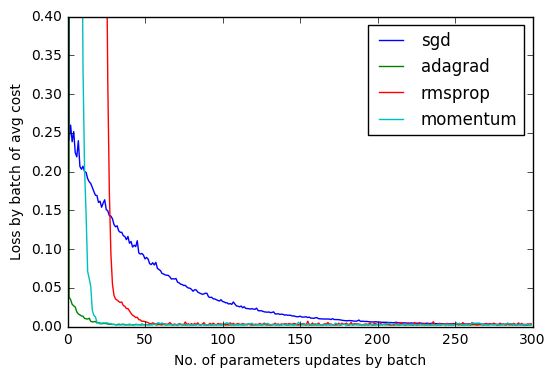

In [8]:
###############################################################################
### theano function
f_model = theano.function([x], y)

f_cost = theano.function([x, y_hat], cost)

f_grad_dw = theano.function([x, y_hat], dw)

f_grad_db = theano.function([x, y_hat], db)

f_train = theano.function(inputs=[x, y_hat],
                          outputs=[cost, w, b],
                          updates=gd([w, b], [dw, db], 0.01))

f_train_adagd = theano.function(inputs=[x, y_hat],
                                outputs=[cost, w, b],
                                updates=Adagd([w, b], [dw, db]))

f_train_rmsprop = theano.function(inputs=[x, y_hat],
                                  outputs=[cost, w, b],
                                  updates=Rmsprop([w, b], [dw, db]))

f_train_momentum = theano.function(inputs=[x, y_hat],
                                   outputs=[cost, w, b],
                                   updates=Momentum([w, b], [dw, db]))

epochs = 300

###############################################################################
# training by gd
his_cost_by_gd = pd.DataFrame(columns=['cost', 'w', 'b'])
tStart = time.time()
for t in range(epochs):
        all_cost = 0
        all_w = 0
        all_b = 0
        
        x_batches, y_batches = mk_batches(x_data, y_data, batch_size, True)        
        batch_num = len(x_batches)      
            
        for i in range(batch_num):            
            tr_cost, tr_w, tr_b= f_train(x_batches[i], y_batches[i])            
            all_cost += tr_cost
        
        his_cost_by_gd.loc[t] = [all_cost/batch_num, tr_w, tr_b]

tEnd = time.time()
print '(Sgd) minimum result \n %s' % (his_cost_by_gd.loc[his_cost_by_gd['cost'].argmin()])
print 'It costs %f sec \n' % (tEnd-tStart)

###############################################################################
# training by adagrad
w.set_value(floatX(-1.))
b.set_value(floatX(-1.))
his_grad_dw = []
his_grad_db = []
second_dw.set_value(floatX(0.))
second_db.set_value(floatX(0.))
his_cost_by_adagd = pd.DataFrame(columns=['cost', 'w', 'b'])
tStart = time.time()
for t in range(epochs):
        all_cost = 0       
        x_batches, y_batches = mk_batches(x_data, y_data, batch_size, True)        
        batch_num = len(x_batches)      
            
        for i in range(batch_num):
            calc_second_derivative(x_batches[i], y_batches[i])            
            tr_cost, tr_w, tr_b= f_train_adagd(x_batches[i], y_batches[i])            
            all_cost += tr_cost            
        
        his_cost_by_adagd.loc[t] = [all_cost/batch_num, tr_w, tr_b]        
        
tEnd = time.time()
print '(Adagrad) minimum result \n %s' % (his_cost_by_adagd.loc[his_cost_by_adagd['cost'].argmin()])
print 'It costs %f sec \n' % (tEnd-tStart)

###############################################################################
# training by rmsprop
w.set_value(floatX(-1.))
b.set_value(floatX(-1.))
his_grad_dw = []
his_grad_db = []
second_dw.set_value(floatX(0.))
second_db.set_value(floatX(0.))
his_cost_by_rmsprop = pd.DataFrame(columns=['cost', 'w', 'b'])
tStart = time.time()
tt = 0
for t in range(epochs):
        all_cost = 0       
        x_batches, y_batches = mk_batches(x_data, y_data, batch_size, True)        
        batch_num = len(x_batches)      
            
        for i in range(batch_num):
            calc_rms_derivative(x_batches[i], y_batches[i], tt)            
            tr_cost, tr_w, tr_b= f_train_rmsprop(x_batches[i], y_batches[i])
            tt += 1
            all_cost += tr_cost            
            
        his_cost_by_rmsprop.loc[t] = [all_cost/batch_num, tr_w, tr_b]        
            
tEnd = time.time()
print '(Rmsprop) minimum result \n %s' % (his_cost_by_rmsprop.loc[his_cost_by_rmsprop['cost'].argmin()])
print 'It costs %f sec \n' % (tEnd-tStart)

###############################################################################
# training by momentum
w.set_value(floatX(-1.))
b.set_value(floatX(-1.))
his_cost_by_momentum = pd.DataFrame(columns=['cost', 'w', 'b'])
tStart = time.time()
tt = 0
for t in range(epochs):
        all_cost = 0       
        x_batches, y_batches = mk_batches(x_data, y_data, batch_size, True)        
        batch_num = len(x_batches)      
            
        for i in range(batch_num):
            calc_momentum(x_batches[i], y_batches[i], tt)            
            tr_cost, tr_w, tr_b= f_train_momentum(x_batches[i], y_batches[i])
            tt += 1
            all_cost += tr_cost            
            
        his_cost_by_momentum.loc[t] = [all_cost/batch_num, tr_w, tr_b]        
            
tEnd = time.time()
print '(Momentum) minimum result \n %s' % (his_cost_by_momentum.loc[his_cost_by_momentum['cost'].argmin()])
print 'It costs %f sec \n' % (tEnd-tStart)

print '(closed-fom) w=0.0639, b= 0.7502'

###############################################################################
### cost chart
plt.plot(his_cost_by_gd.iloc[:, 0], label='sgd')
plt.plot(his_cost_by_adagd.iloc[:, 0], label='adagrad')
plt.plot(his_cost_by_rmsprop.iloc[:, 0], label='rmsprop')
plt.plot(his_cost_by_momentum.iloc[:, 0], label='momentum')
plt.legend()
plt.xlabel("No. of parameters updates by batch")
plt.ylabel("Loss by batch of avg cost")
plt.ylim([0, 0.4])
plt.show()